**Table of contents**<a id='toc0_'></a>    
- [Import des modules](#toc1_)    
- [Analyse univariée](#toc2_)    
  - [Features numériques](#toc2_1_)    
  - [Features catégorielles](#toc2_2_)    
- [Analyse bivariée](#toc3_)    
  - [Features numériques](#toc3_1_)    
  - [Features numérique/catégorielles](#toc3_2_)    
- [Analyse multi-variée](#toc4_)    
  - [ACP](#toc4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Import des modules](#toc0_)

In [1]:
import os
import pandas as pd
import numpy as np
from base64 import b64encode
from io import BytesIO

from IPython.display import Markdown as md, display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import itertools

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe' 
pd.set_option("display.max_columns", None)

working_dir = "working"

if not os.path.exists(working_dir):
    os.mkdir(working_dir)

In [2]:
df = pd.read_parquet(f"{working_dir}/fully_cleaned.parquet", )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731005 entries, 0 to 731004
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                731005 non-null  object 
 1   product_name        731005 non-null  object 
 2   nutriscore_score    731005 non-null  float64
 3   nutriscore_grade    731005 non-null  object 
 4   pnns_groups_1       731005 non-null  object 
 5   pnns_groups_2       731005 non-null  object 
 6   food_groups_tags    731005 non-null  object 
 7   energy-kcal_100g    731005 non-null  float64
 8   fat_100g            731005 non-null  float64
 9   saturated-fat_100g  731005 non-null  float64
 10  carbohydrates_100g  731005 non-null  float64
 11  sugars_100g         731005 non-null  float64
 12  proteins_100g       731005 non-null  float64
 13  salt_100g           731005 non-null  float64
 14  sodium_100g         731005 non-null  float64
dtypes: float64(9), object(6)
memory us

In [4]:
df.describe(include="all")

,code,product_name,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups_tags,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
count,731005,731005,731005.000000,731005,731005,731005,731005,731005.000000,731005.000000,731005.000000,731005.000000,731005.000000,731005.000000,731005.000000,731005.000000
unique,731005,515241,NaN,5,11,40,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00000000000026772226,Miel,NaN,d,Sugary snacks,Biscuits and cakes,"en:sugary-snacks,en:sweets",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,721,NaN,227420,164829,67152,68604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,9.187625,NaN,NaN,NaN,NaN,268.094103,13.631830,5.161737,26.053026,13.162541,8.621888,1.143205,0.470515
std,NaN,NaN,8.459254,NaN,NaN,NaN,NaN,186.103362,17.155008,7.650860,27.211363,19.557599,9.757296,3.609259,1.559755
min,NaN,NaN,-15.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.113076,0.000000,0.000000,0.000000
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,111.000000,0.800000,0.100000,2.500000,0.500000,1.200000,0.030000,0.012000
50%,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,253.000000,7.300000,1.900000,13.000000,3.100000,6.000000,0.500000,0.200000
75%,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,389.000000,21.000000,7.500000,51.000000,18.000000,12.600000,1.300000,0.520000


## <a id='toc2_'></a>[Analyse univariée](#toc0_)

In [5]:
num_cols = []
cat_cols = []
for c in df.columns:
    if df.dtypes[c]=="float64":
        num_cols.append(c)
    else:
        cat_cols.append(c)


### <a id='toc2_1_'></a>[Features numériques](#toc0_)

In [6]:
def add_split_screen(title, html, figsdata, iwidth=None):
    
    iwidth = ' width={0} '.format(iwidth) if iwidth is not None else ''
    datatable = f"""<table><tr><td colspan="{1 + len(figsdata)}" align="center"><h1>{title}</h1></td></tr><tr><td>{html}</td>"""
    for figdata in figsdata:
        datatable += f"""<td><img src="data:image/png;base64,{b64encode(figdata.getvalue()).decode()}"/></td>"""
    datatable += """</tr></table>"""

    display(HTML(datatable)) 



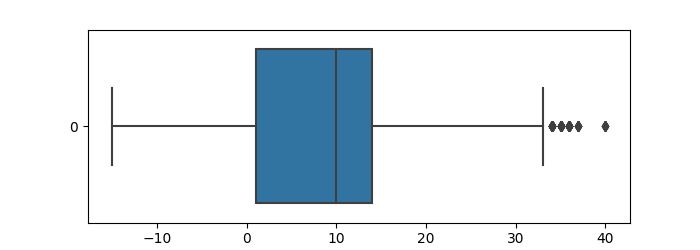
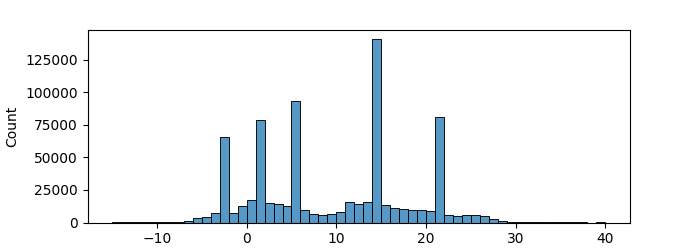


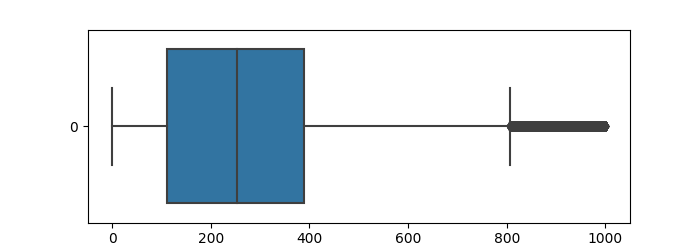
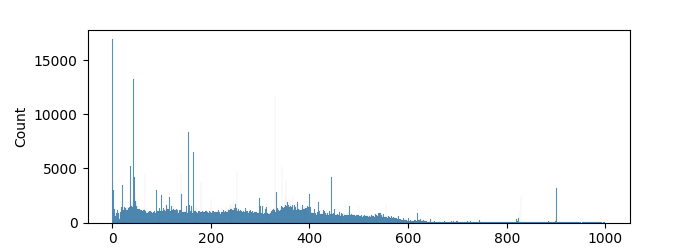


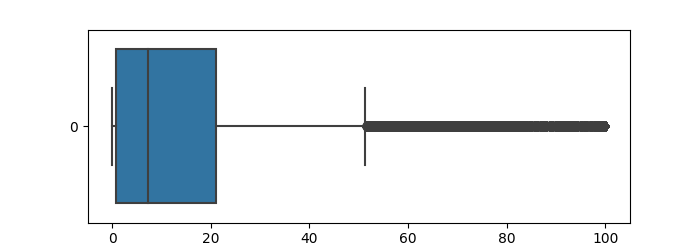
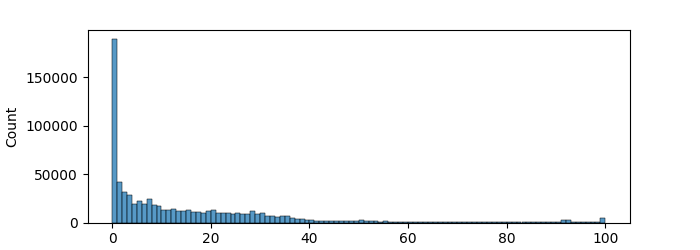


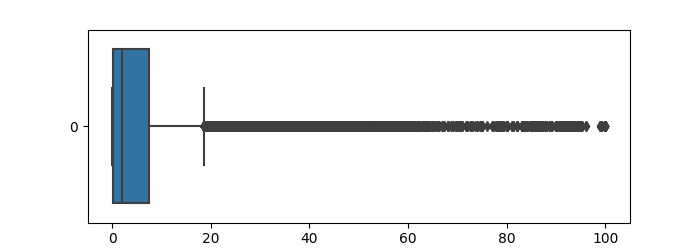
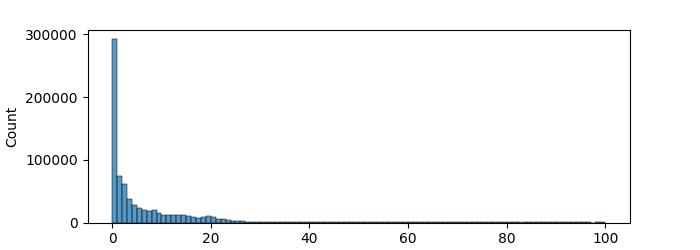


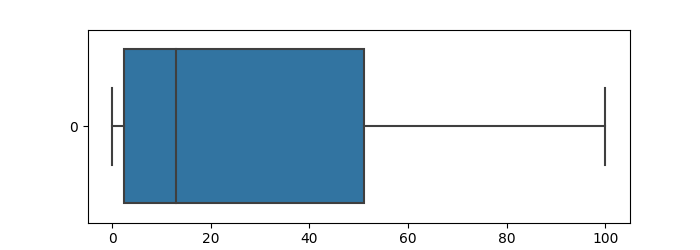
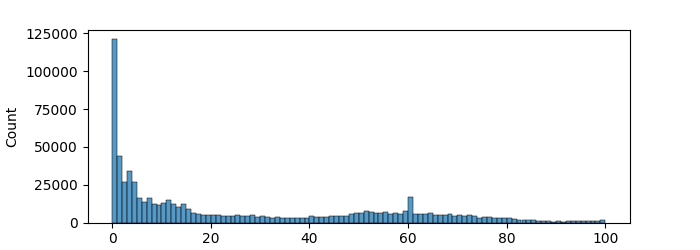


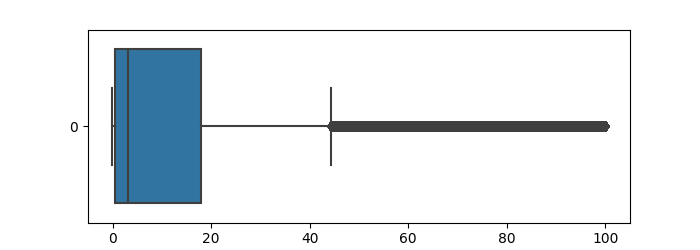
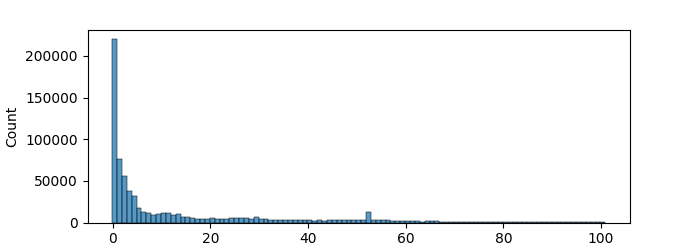


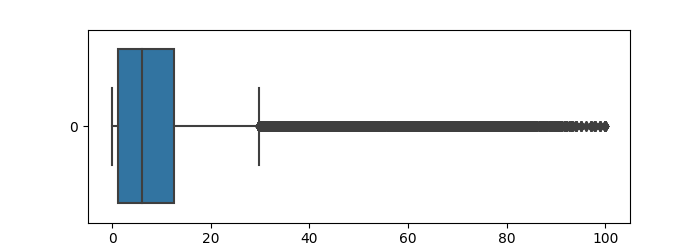
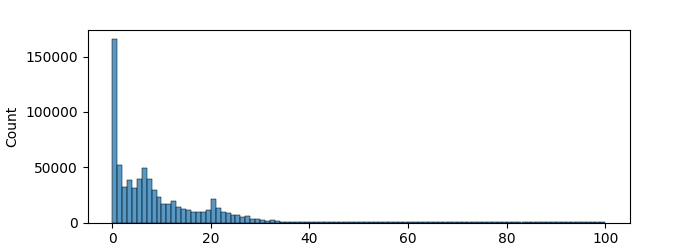


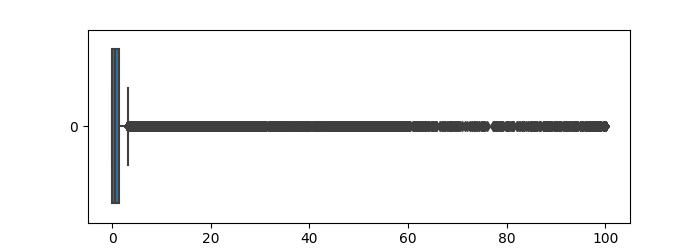
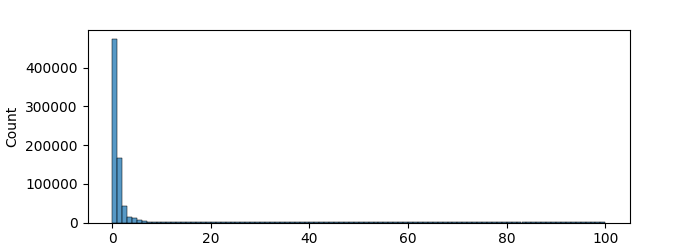


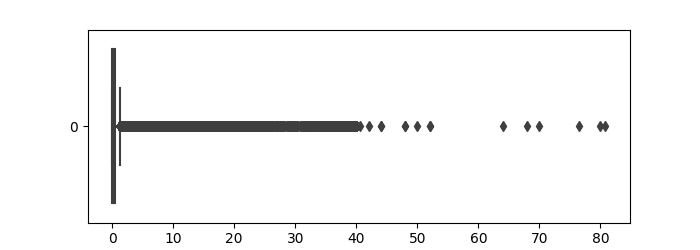
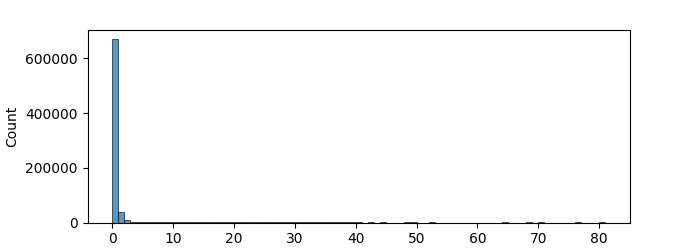

In [7]:
for c in num_cols:
    df[c] = np.array(df[c], dtype=np.float64)
    d = df[c].describe().to_dict()
    d_html = "<table>"
    for t in d:
        d_html += f"""<tr><td>{t}</td><td align="right">{d[t]}</td></tr>"""
    d_html += f"""<tr><td>skewness</td><td align="right">{skew(df[c])}</td></tr>"""
    d_html += f"""<tr><td>kurtosis</td><td align="right">{kurtosis(df[c])}</td></tr>"""

    d_html += "</table>"
    
    fig1data = BytesIO()
    plt.figure(figsize=(7,2.5))
    sns.boxplot(data=df[c], orient="h")
    plt.savefig(fig1data)
    plt.close()

    fig2data = BytesIO()
    plt.figure(figsize=(7,2.5))
    sns.histplot(data=df[c], kde=False, binwidth=1)
    plt.savefig(fig2data)
    plt.close()

    add_split_screen(c, d_html, [fig1data, fig2data])
    


On constate visuellement, et via le couple skewness/kurtosis qu'aucune des distributions des features numériques n'est de forme normale.

### <a id='toc2_2_'></a>[Features catégorielles](#toc0_)
Les features "code" et "product_name" ayant trop de valeurs uniques, nous ne les utiliserons pas dans notre analyse bi-variée.

In [8]:
cat_cols

['code',
 'product_name',
 'nutriscore_grade',
 'pnns_groups_1',
 'pnns_groups_2',
 'food_groups_tags']

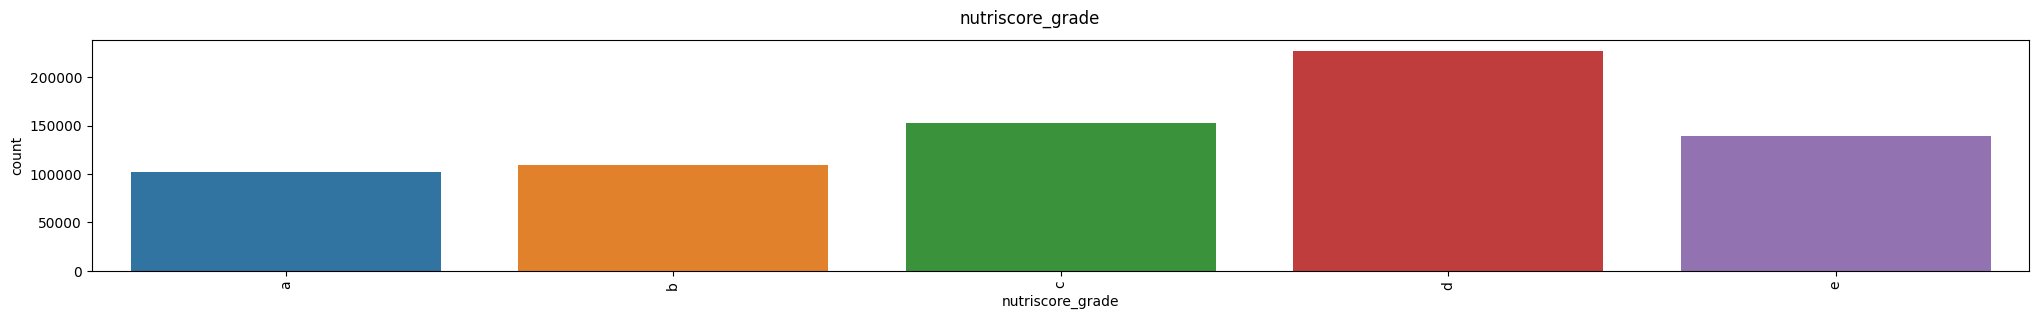

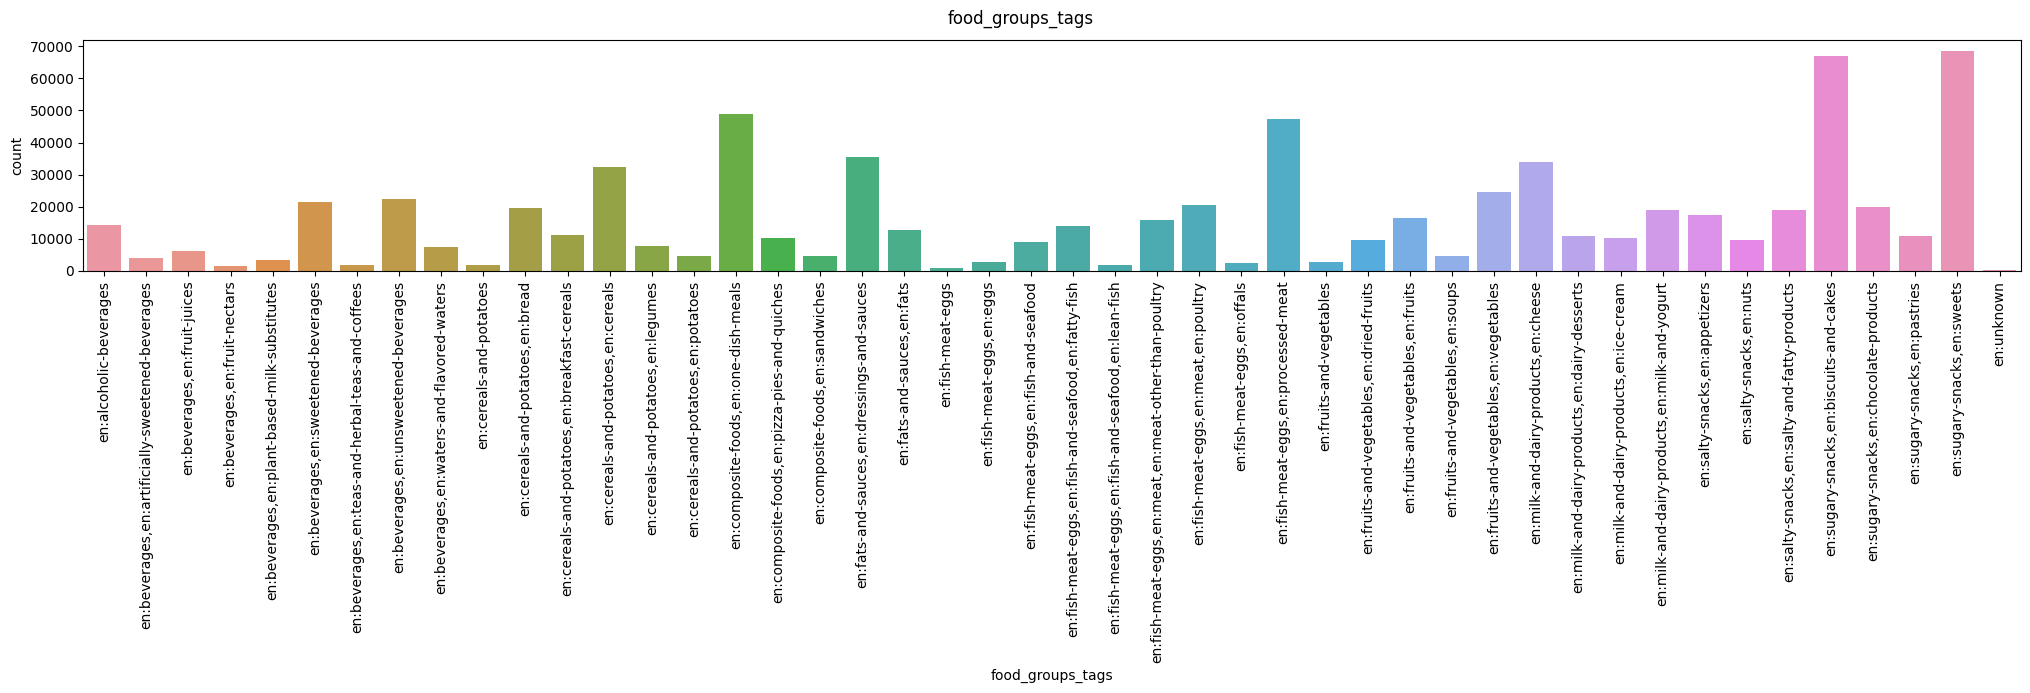

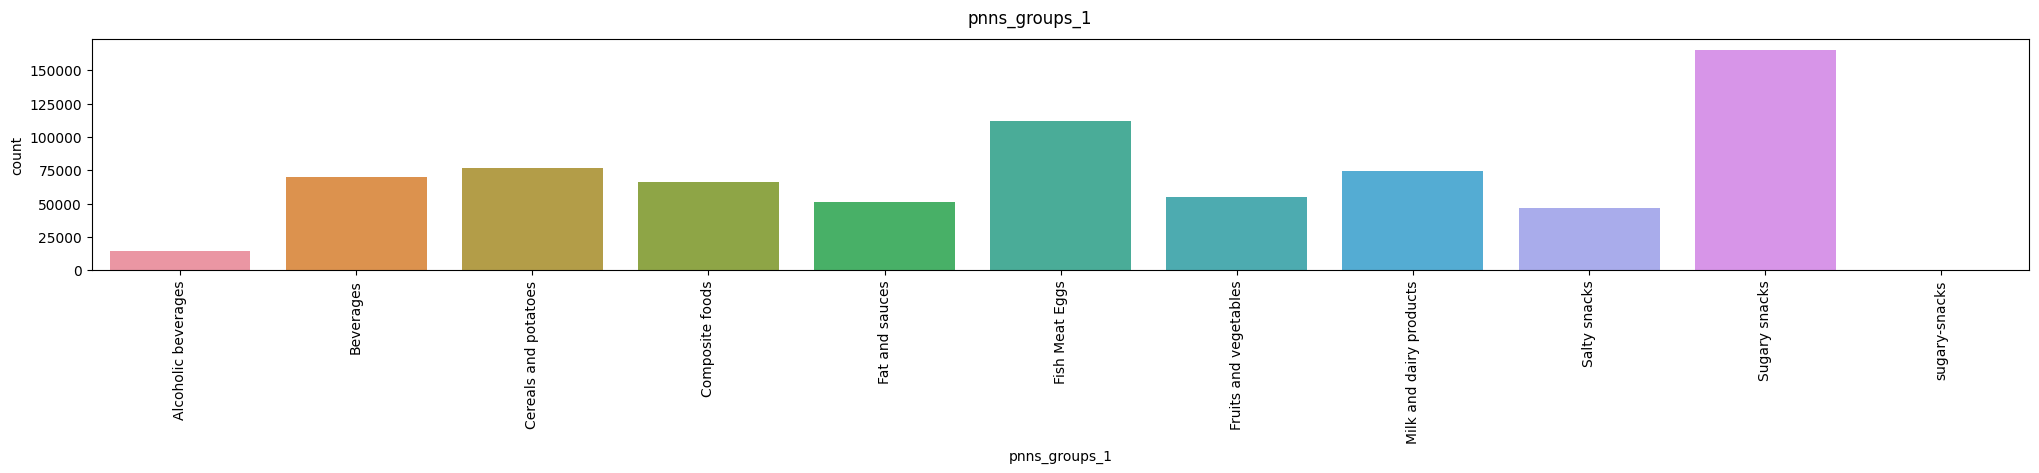

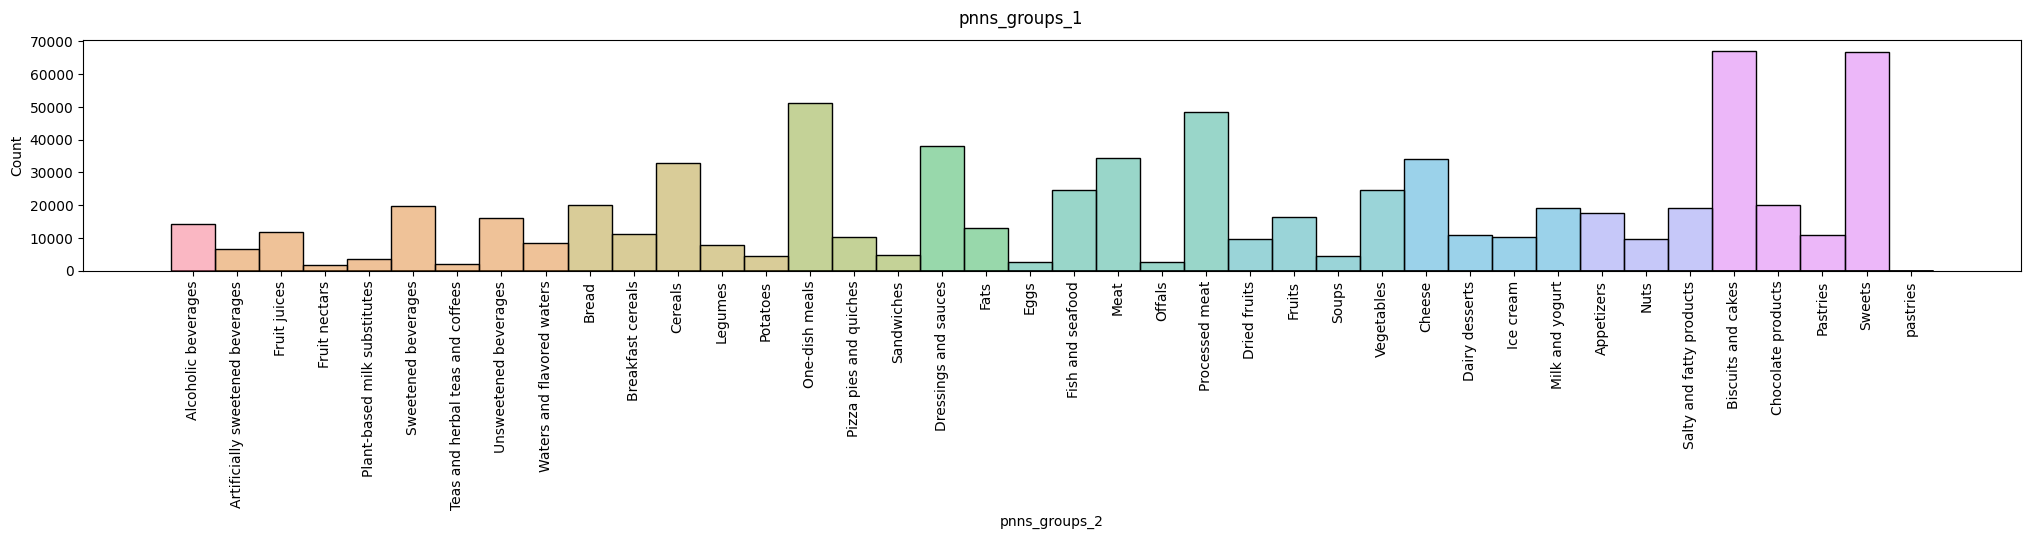

In [9]:

for c in ["nutriscore_grade", "food_groups_tags", "pnns_groups_1"]:
    if c in ["code", "product_name"]:
        continue
    f = plt.figure(figsize=(25,3))
    #plt.subplot(1,1,1)
    g = sns.countplot(x=df.sort_values(c)[c])
    plt.xticks(rotation=90)
    f.suptitle(c)
    plt.show()

f = plt.figure(figsize=(25,3))
#plt.subplot(1,1,1)
g = sns.histplot(data=df.sort_values(["pnns_groups_1", "pnns_groups_2"]), x="pnns_groups_2", hue="pnns_groups_1", legend=False)
plt.xticks(rotation=90)
f.suptitle(c)
plt.show()



## <a id='toc3_'></a>[Analyse bivariée](#toc0_)

In [10]:
out = "| Variables catégorielles | Nb valeurs distinctes |\n"
out += "|----------|----------|\n"
for c in cat_cols:
    out += f"| {c} | {df[c].unique().shape[0]} |\n"

display(md(out))

| Variables catégorielles | Nb valeurs distinctes |
|----------|----------|
| code | 731005 |
| product_name | 515241 |
| nutriscore_grade | 5 |
| pnns_groups_1 | 11 |
| pnns_groups_2 | 40 |
| food_groups_tags | 46 |


### <a id='toc3_1_'></a>[Features numériques](#toc0_)

<Figure size 2500x2500 with 0 Axes>

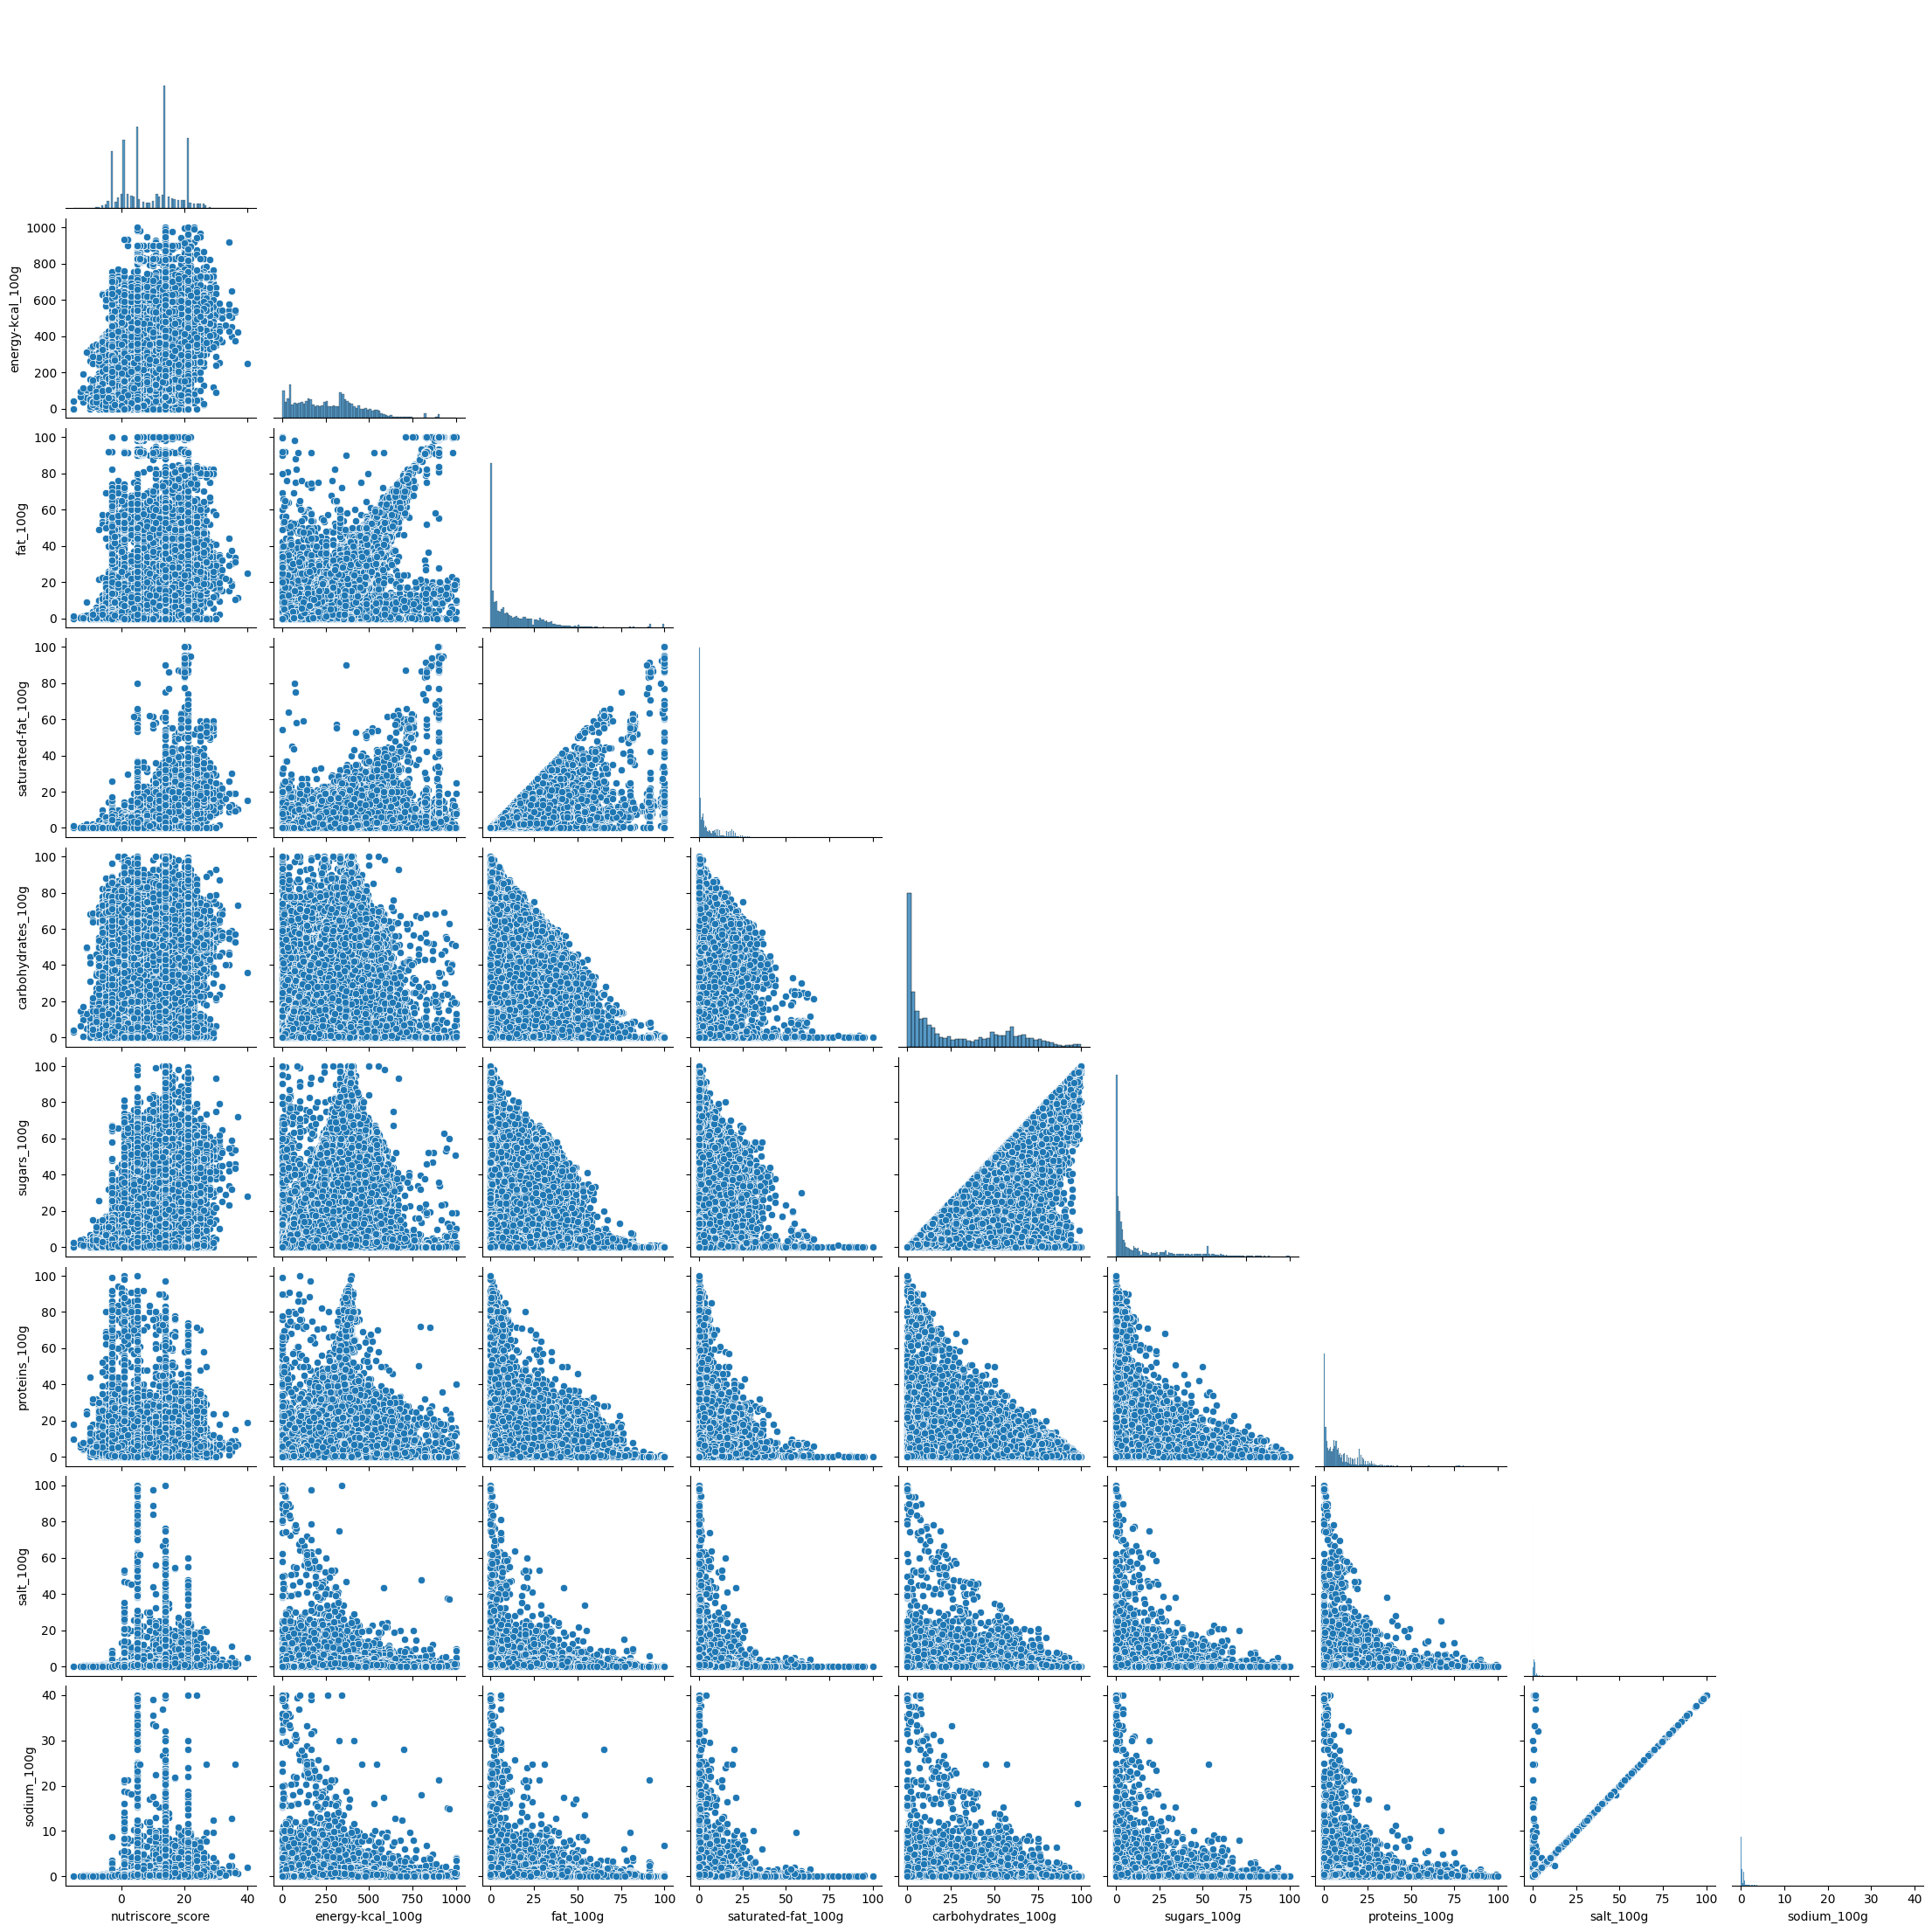

In [11]:
f = plt.figure(figsize=(25,25))
g = sns.pairplot(df.sample(frac=0.1).loc[:, num_cols], corner = True)
f.suptitle(c)
plt.show()


On constate avec le graphe: 
- energy-kcal_100g évolue avec fat_100g : expliqué par la formule de l'énergie et le gros coefficient pour les lipides
- nutriscore_score évolue avec saturated-fat_100g et dans une moindre mesure avec fat_100g
- nutriscore_score évolue avec sugars_100g
- salt_100g et sodium_100g ont une forte relaltion linéaire : expliqué par le fait que le sodium est apporté principalement par le sel, et que le sel contient du sodium

Vérifions via un clustermap des correspondances:


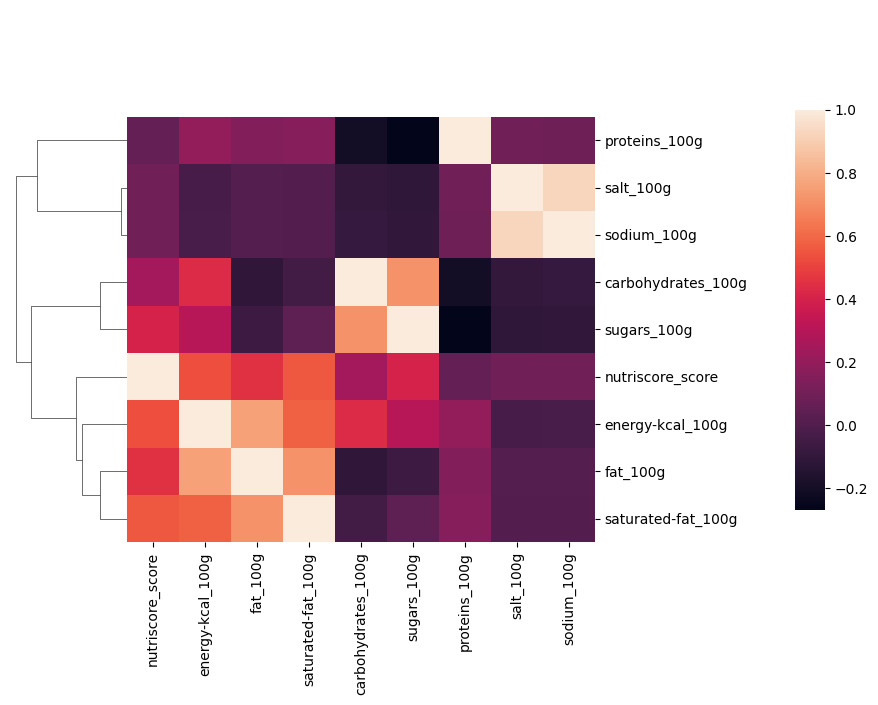

In [12]:
g = sns.clustermap(df.loc[:, num_cols].corr(), col_cluster=False)
g.fig.subplots_adjust(right=0.6, top=0.7)
g.ax_cbar.set_position((0.8, .2, .03, .4))


### <a id='toc3_2_'></a>[Features numérique/catégorielles](#toc0_)

In [13]:
out = "| Variables catégorielles | Nb valeurs distinctes |\n"
out += "|----------|----------|\n"
for c in cat_cols:
    out += f"| {c} | {df[c].unique().shape[0]} |\n"

display(md(out))

| Variables catégorielles | Nb valeurs distinctes |
|----------|----------|
| code | 731005 |
| product_name | 515241 |
| nutriscore_grade | 5 |
| pnns_groups_1 | 11 |
| pnns_groups_2 | 40 |
| food_groups_tags | 46 |


On voit que les features numériques sur lesquelles nous pourrons faire une analyse bivariée sont "nutriscore_grade" et "pnns_groups_1". Pour les autres, il y a trop de valeurs distinctes.

In [14]:
g = sns.pairplot(df.sample(frac=0.1).sort_values("nutriscore_grade").loc[:, ["nutriscore_grade"] + num_cols], hue="nutriscore_grade", corner = True, markers="+", plot_kws={'alpha':0.1})
g._legend.set_bbox_to_anchor((0.6, 0.7))
plt.savefig(f"./{working_dir}/bivarie/matrixplot_par_nutrigrade.png")
plt.close()

display(HTML(f"""<img src="./{working_dir}/bivarie/matrixplot_par_nutrigrade.png"">"""))

La visualisation des scatterplots par nutriscore-grade ne nous donne aucune information particulière.

    

In [15]:
sns.pairplot(df.sample(frac=0.1).sort_values("pnns_groups_1").loc[:, ["pnns_groups_1"] + num_cols], hue="pnns_groups_1", markers="+", corner = True, plot_kws={'alpha':0.1})
plt.savefig(f"./{working_dir}/bivarie/matrixplot_par_pnns_groups_1.png")
plt.close()

display(HTML(f"""<img src="./{working_dir}/bivarie/matrixplot_par_pnns_groups_1.png"">"""))

In [16]:
tmp_df = df.sort_values("nutriscore_grade")
if not os.path.exists(f"{working_dir}/bivarie"):
    os.mkdir(f"./{working_dir}/bivarie")
for c in num_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=tmp_df[c], x=tmp_df["nutriscore_grade"])
    if c in ["salt_100g", "sodium_100g"]:
        plt.yscale("symlog") 
        plt.ylim(-0.1,100)
    plt.savefig(f"./{working_dir}/bivarie/boxplot_{c}_par_nutrigrade.png")
    plt.close()

    fig = plt.figure(figsize=(10,5))
    sns.histplot(data=tmp_df, x=c, hue="nutriscore_grade", kde=True, multiple="dodge")
    plt.savefig(f"./{working_dir}/bivarie/histplot_{c}_par_nutrigrade.png")
    plt.close()

    
    d_html = f"""<div><img src="./{working_dir}/bivarie/boxplot_{c}_par_nutrigrade.png" ></div><div><img src="./{working_dir}/bivarie/histplot_{c}_par_nutrigrade.png" ></div>"""
    add_split_screen(c, d_html, [])

nutriscore_score
""


energy-kcal_100g
""


fat_100g
""


saturated-fat_100g
""


carbohydrates_100g
""


sugars_100g
""


proteins_100g
""


salt_100g
""


sodium_100g
""


In [17]:
tmp_df = df.sort_values("pnns_groups_1")
for c in num_cols:
    plt.figure(figsize=(15,7))
    sns.boxplot(y=tmp_df[c], x=tmp_df["pnns_groups_1"])
    plt.xticks(rotation=60)
    
    if c in ["salt_100g", "sodium_100g"]:
        plt.yscale("symlog") 
        plt.ylim(-0.1,100)
    
    plt.subplots_adjust(bottom=0.35)
    plt.savefig(f"./{working_dir}/bivarie/boxplot_{c}_par_pnns_groups_1.png")
    plt.close()
    d_html = f"""<img src="./{working_dir}/bivarie/boxplot_{c}_par_pnns_groups_1.png" >"""

 

    add_split_screen(c, d_html, [])
    

nutriscore_score
""


energy-kcal_100g
""


fat_100g
""


saturated-fat_100g
""


carbohydrates_100g
""


sugars_100g
""


proteins_100g
""


salt_100g
""


sodium_100g
""


# <a id='toc4_'></a>[Analyse multi-variée](#toc0_)

## <a id='toc4_1_'></a>[ACP](#toc0_)

On commence par récupérer les colonnes numériques. Nous allons utiliser la colonne nutriscore_score pour le nutriscore.

In [18]:
#num_cols.remove("nutriscore_score")

In [19]:
X = df.loc[:, num_cols].reset_index(drop=True).values

Nous mettons nos valeurs à l'échelle

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
n_components = len(num_cols)
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=9)

In [22]:
pca.explained_variance_ratio_

array([0.32924513, 0.24036108, 0.1939657 , 0.09598536, 0.06521223,
       0.03317632, 0.02750623, 0.00823399, 0.00631396])

In [23]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(range(1, n_components+1)),
        y=pca.explained_variance_ratio_ * 100,
        hoverinfo='x+y',
        name="Variance expliquée" 
    ),
)
fig.add_trace(
    go.Scatter(
        x=list(range(1, n_components+1)), 
        y=np.cumsum(pca.explained_variance_ratio_*100),
        mode='lines',
        name='Variance expliquée cumulée'
    )
)

fig.update_layout(
    title=f"""Ebouli des valeurs propres avec {n_components} composantes""",
    title_x=0.5,
    autosize=False,
    width=800,
    height=600,
    legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=0.99
    )
)
fig.show()

On voit que 86% de la variance est comprise dans les 4 premères composantes.

In [24]:
pcs = pd.DataFrame(pca.components_, columns=num_cols)
pcs.index = [f"F{i}" for i in range(1, n_components+1)]

In [25]:
pca.components_

array([[ 4.52029482e-01,  5.22665149e-01,  4.58012948e-01,
         4.54375902e-01,  2.11717966e-01,  2.33636379e-01,
         8.27319952e-02, -1.45379751e-03,  1.26809814e-04],
       [ 1.37732213e-02, -1.89900324e-02,  2.02771653e-01,
         1.65938386e-01, -4.21732840e-01, -4.24318589e-01,
         2.96268509e-01,  4.94768347e-01,  4.90226667e-01],
       [ 1.42206918e-01, -2.30914322e-02, -2.59312956e-01,
        -2.04780854e-01,  4.03539181e-01,  3.99984508e-01,
        -2.25144453e-01,  4.95760415e-01,  5.00765095e-01],
       [-7.57880876e-02,  1.74670321e-01, -2.20455586e-01,
        -2.28607269e-01,  2.74413124e-01,  7.09318254e-02,
         8.83630624e-01, -2.65731108e-02, -3.22707233e-02],
       [-6.70346668e-01,  4.62057124e-01,  3.36225163e-01,
        -1.98629071e-01,  3.02070031e-01, -2.16385201e-01,
        -1.87745150e-01,  7.12611663e-02,  7.90090909e-02],
       [-4.63249736e-01, -1.97832399e-01, -2.61972941e-01,
         7.84728355e-01,  1.94684759e-01,  1.255448

In [26]:
def correlation_graph2(pca, x_y, features): 
    colors_cycle = itertools.cycle(px.colors.qualitative.Dark24)

    x,y=x_y

    fig = go.Figure()
    fig.add_shape(
        type="circle",
        xref="x", yref="y",
        x0=-1, y0=-1, x1=1, y1=1,
        line_color="Black",
    )
    
    for i in range(0, pca.components_.shape[1]):
        color = next(colors_cycle)
        fig.add_annotation(
            x=pca.components_[x, i],
            y=pca.components_[y, i],
            xref="x", yref="y",
            showarrow=True,
            axref = "x", ayref='y',
            ax=0,
            ay=0,
            arrowhead=4,
            arrowwidth=2,
            arrowcolor=color,
            font=dict(
                color=color,
                size=12
            ),
        )
        fig.add_trace(
            go.Scatter(
                x=[pca.components_[x, i]],
                y=[pca.components_[y, i]],
                text=[features[i]],
                mode='text',
                marker=dict(
                    color = color
                ),
                name=features[i]
            ), 
        )
        
    fig.update_layout(width=1000, height=800,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    fig.update_xaxes(range=[-1.1, 1.1], title=dict(text = f"F{x+1}"))
    fig.update_yaxes(range=[-1.1, 1.1], title=dict(text = f"F{y+1}"))
    
    fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color))
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1,
    )
    fig.show()


In [27]:
correlation_graph2(pca, (0,1), num_cols)

In [28]:
correlation_graph2(pca, (1,2), num_cols)

In [29]:
correlation_graph2(pca, (2,3), num_cols)

Les cercles de corrélation nous montrent que :
- le nutriscore_score évolue avec energy-kcal_100g, fat_100g et fat-saturated_100g dans les 2 premières composantes
- il existe une forte relation entre carbohydrates_100g et sugars_100g (expliqué par l'appartenance des sucres aux carbohydrates)
- nutriscore_score évolue dans les composantes F3 et F4 avec salt_100g/sodium_100g


### Projection selon les axes de la PCA

In [30]:
df_proj = pd.DataFrame(pca.transform(X_scaled), columns=[f"F{i}" for i in range(1, n_components+1)] )
df_proj["nutriscore_grade"] = df["nutriscore_grade"]
df_proj["pnns_groups_1"] = df["pnns_groups_1"]

In [31]:
df_proj_subset = df_proj.sample(frac=0.1).sort_values("nutriscore_grade").reset_index()

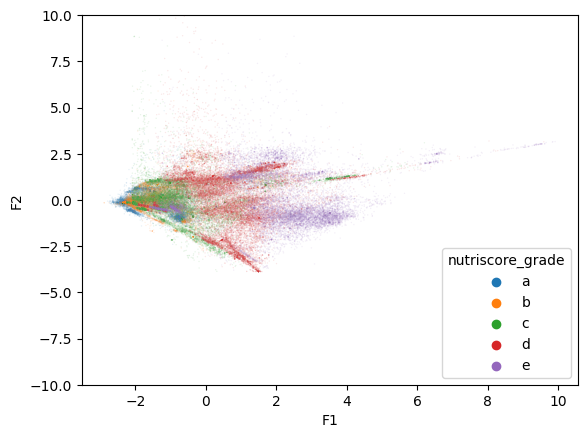

In [32]:
sns.scatterplot(data=df_proj_subset, x="F1", y="F2", hue="nutriscore_grade", s=1, alpha=0.1)
plt.ylim(-10, 10)

plt.show()


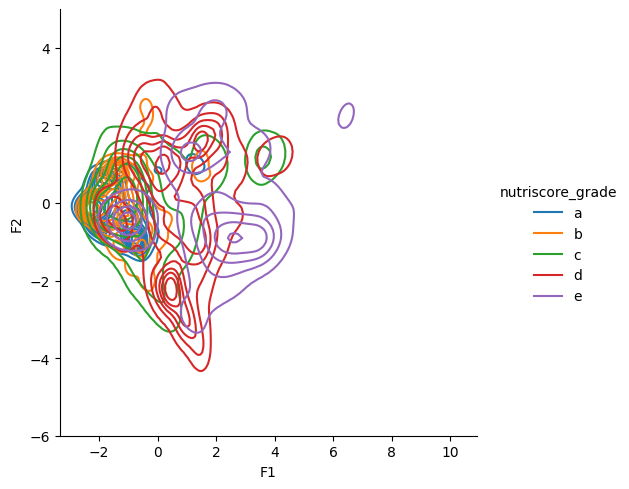

In [33]:
g = sns.displot(df_proj_subset, x="F1", y="F2",hue="nutriscore_grade", kind="kde")
plt.ylim(-6, 5)
plt.show()


On voit que l'axe F1 évolue avec le nutriscore

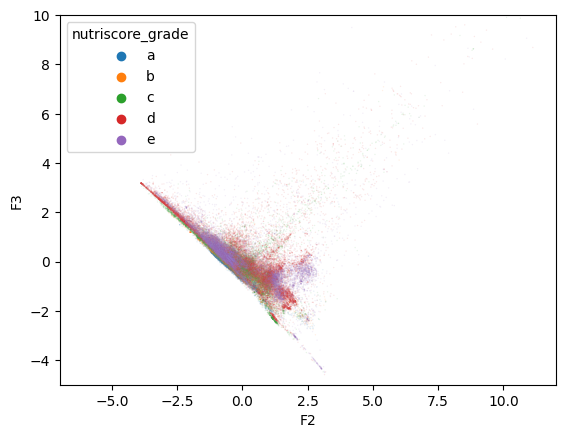

In [34]:
sns.scatterplot(data=df_proj_subset, x="F2", y="F3", hue="nutriscore_grade", s=1, alpha=0.1)
plt.xlim(-7, 12)
plt.ylim(-5, 10)

plt.show()


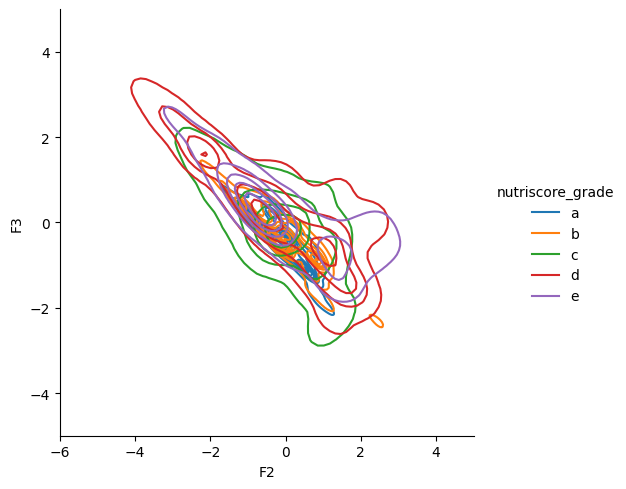

In [35]:
g = sns.displot(df_proj_subset, x="F2", y="F3", hue="nutriscore_grade", kind="kde")
plt.xlim(-6, 5)
plt.ylim(-5, 5)

plt.show()

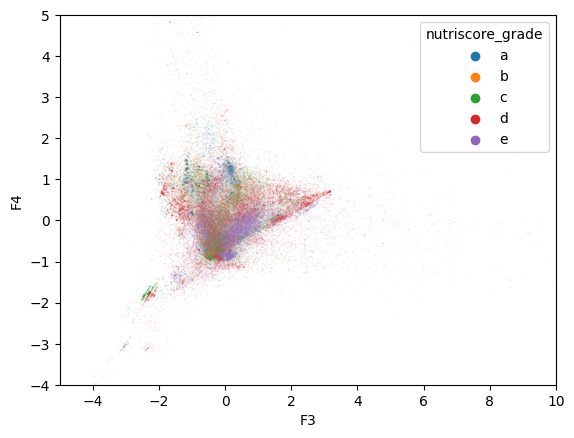

In [36]:
sns.scatterplot(data=df_proj_subset, x="F3", y="F4", hue="nutriscore_grade", s=1, alpha=0.1)
plt.xlim(-5, 10)
plt.ylim(-4, 5)
plt.show()


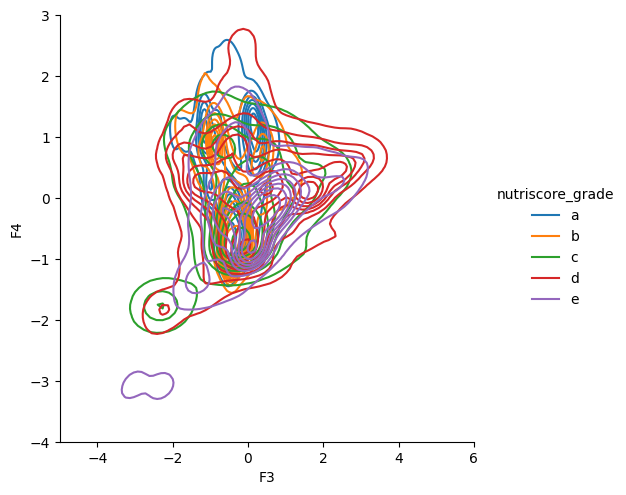

In [37]:
g = sns.displot(df_proj_subset, x="F3", y="F4", hue="nutriscore_grade", kind="kde")
plt.xlim(-5, 6)
plt.ylim(-4, 3)

plt.show()

## ANOVA

Nous allons analyser la corrélation entre le nutriscore_grade et les features numériques.

In [38]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    

In [39]:
cat_cols

['code',
 'product_name',
 'nutriscore_grade',
 'pnns_groups_1',
 'pnns_groups_2',
 'food_groups_tags']

In [40]:
for cat_col in ["nutriscore_grade", "food_groups_tags", "pnns_groups_1", "pnns_groups_2"]:
    out = f"| Feature | ETA² | Corrélation avec {cat_col} |\n"
    out += "|-----------|-----------|-----------|\n"
    etas = {}

    for c in num_cols:
        etas[c] = eta_squared(df[cat_col], df[c])

    etas = dict(sorted(etas.items(), key=lambda item: item[1], reverse=True))
    for c in etas:
        effect_size = "Négligeable"
        if etas[c] >= 0.14:
            effect_size = "Grande"
        elif etas[c] >= 0.06:
            effect_size = "Moyenne"
        elif etas[c] >= 0.01:
            effect_size = "Petite"
        out += f"""| {c} | {etas[c]} | {effect_size} |\n"""

    display(md(out))


| Feature | ETA² | Corrélation avec nutriscore_grade |
|-----------|-----------|-----------|
| nutriscore_score | 0.954253874690802 | Grande |
| saturated-fat_100g | 0.29624457377844865 | Grande |
| energy-kcal_100g | 0.24950461263213133 | Grande |
| fat_100g | 0.1835284286662641 | Grande |
| sugars_100g | 0.15093297825753427 | Grande |
| carbohydrates_100g | 0.059877145327455396 | Petite |
| salt_100g | 0.015406626756789932 | Petite |
| sodium_100g | 0.014216956058932287 | Petite |
| proteins_100g | 0.012199277285963806 | Petite |


| Feature | ETA² | Corrélation avec food_groups_tags |
|-----------|-----------|-----------|
| carbohydrates_100g | 0.6911632776419778 | Grande |
| sugars_100g | 0.6316003764218523 | Grande |
| energy-kcal_100g | 0.624208012549398 | Grande |
| fat_100g | 0.6174941758444954 | Grande |
| saturated-fat_100g | 0.4919286739740973 | Grande |
| nutriscore_score | 0.4660355205516018 | Grande |
| proteins_100g | 0.44703194078469344 | Grande |
| salt_100g | 0.068972871966833 | Moyenne |
| sodium_100g | 0.05962036502393835 | Petite |


| Feature | ETA² | Corrélation avec pnns_groups_1 |
|-----------|-----------|-----------|
| carbohydrates_100g | 0.5851776700372304 | Grande |
| sugars_100g | 0.4983986876146268 | Grande |
| energy-kcal_100g | 0.39018686043077444 | Grande |
| proteins_100g | 0.331095435662938 | Grande |
| nutriscore_score | 0.3026482572392244 | Grande |
| fat_100g | 0.26114362242580985 | Grande |
| saturated-fat_100g | 0.17866275531397405 | Grande |
| salt_100g | 0.043316342447549436 | Petite |
| sodium_100g | 0.037453634375106105 | Petite |


| Feature | ETA² | Corrélation avec pnns_groups_2 |
|-----------|-----------|-----------|
| carbohydrates_100g | 0.7067666400613435 | Grande |
| sugars_100g | 0.6509852428686291 | Grande |
| energy-kcal_100g | 0.6319130112272252 | Grande |
| fat_100g | 0.6168495343254533 | Grande |
| saturated-fat_100g | 0.49102575882787564 | Grande |
| nutriscore_score | 0.46505020647835066 | Grande |
| proteins_100g | 0.4415820651326931 | Grande |
| salt_100g | 0.06917498327336419 | Moyenne |
| sodium_100g | 0.059687994815023605 | Petite |


## Test d'indépendance des features categorielles

Nous allons voir si nutriscore_grade est indépendant des features pnns_groups_1, pnns_groups_2 et food_groups_tags.

Pour cela nous allons utiliser le test Chi2, via la fonction scipy.stats import chi2_contingency. Celle-ci retourne:
- la valeur du test Chi2 (excellente explication sur : https://www.youtube.com/watch?v=Zju98CyKi9c )
- la valeur du test p-value
- le nombre de degrés de liberté
- le tableau des fréquances attendues
(Encore une fois tout est expliqué sur https://www.youtube.com/watch?v=Zju98CyKi9c )

On prend pour limite alpha du test: 0.05

Si p-value < 0.05, on rejette l'hypothèse H0: les variables ne sont pas indépendantes sinon on la retient

In [41]:
alpha = 0.05
out = "|Var 1 | Var 2 | p-value | Chi2 | Conclusion |\n"
out += "|------------|------------|------------|------------|------------------------------------------------|\n"
cols_tested = []
for col0 in ["nutriscore_grade", "food_groups_tags", "pnns_groups_2"]:
    for col in ["nutriscore_grade", "food_groups_tags", "pnns_groups_2"]:
        if col0==col:
            continue
        if col+"x"+col0 in cols_tested:
            continue
        t_cont = pd.crosstab(df[col0], df[col])
        stat_chi2, p, dof, expected_table = chi2_contingency(t_cont.values)
        out += f"| {col0} | {col} | {p} | {stat_chi2} | "
        if p<alpha:
            out += f"nutriscore_grade et {col} ne sont pas indépendantes car p={p} < {alpha}"
        else:
            out += f"nutriscore_grade et {col} indépendantes car p={p} >= {alpha}"
        out += " |\n"
        cols_tested.append(col0+"x"+col)
display(md(out))

|Var 1 | Var 2 | p-value | Chi2 | Conclusion |
|------------|------------|------------|------------|------------------------------------------------|
| nutriscore_grade | food_groups_tags | 0.0 | 596902.354355074 | nutriscore_grade et food_groups_tags ne sont pas indépendantes car p=0.0 < 0.05 |
| nutriscore_grade | pnns_groups_2 | 0.0 | 593950.2982257227 | nutriscore_grade et pnns_groups_2 ne sont pas indépendantes car p=0.0 < 0.05 |
| food_groups_tags | pnns_groups_2 | 0.0 | 25840325.437873654 | nutriscore_grade et pnns_groups_2 ne sont pas indépendantes car p=0.0 < 0.05 |
